# Implementation of mathematical morphology on earth observation data.

This notebook replicate the workflow of the analysis done in the ["Extraction of bridges over water from high-resolution optical remote-sensing images based on mathematical morphology"](https://www.tandfonline.com/doi/pdf/10.1080/01431161.2014.915437?needAccess=true
). 

The analysis steps in this paper were split into 4 main parts: 
- image preprocessing
- water extraction using histogram-based thresholding
- bridge extraction
- post processing using prior knowledge

## Workspace Utilities
This notebook was created in a Google colab working environment and installed some of the libraries that are not directly available in the environment. 
If a different environment is used to replicate this notebook, this section of the notebook can be commented out. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [ ]:
! pip install rasterio

In [44]:
import rasterio
import skimage
from skimage import morphology
from rasterio import plot
import numpy as np
import matplotlib.pyplot as plt

## Image pre-processing

In [6]:

from skimage.filters import threshold_otsu
from skimage.io import imread, imshow
# https://www.analyticsvidhya.com/blog/2019/09/9-powerful-tricks-for-working-image-data-skimage-python/

image = imread("UBS/Computer Vision/Data/qb_bmn311_subset.img")[:, :, -1]

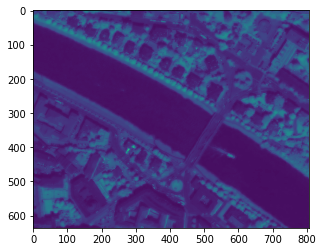

In [7]:
# show the original image
plt.imshow(image)

Text(0.5, 1.0, 'Gaussian Filtered Image')

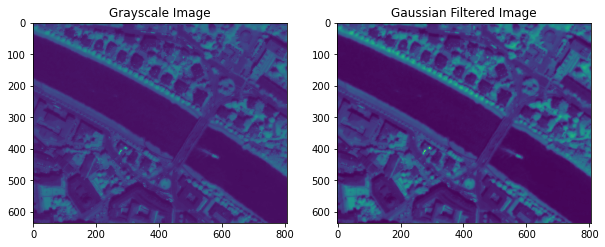

In [25]:

grayscale = skimage.color.rgb2gray(image)
gauss_filt = skimage.filters.gaussian(grayscale, sigma=0.8)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(grayscale)
ax1.set_title("Grayscale Image")

ax2.imshow(gauss_filt)
ax2.set_title("Gaussian Filtered Image")

In this section of the notebook, the focus was on emphasizng the appearance of each of the image element including the bridge that passed over the water, that was initially blurred.

## Water extraction
To extract the water pixels, an **histogram-based thresholding** (Otsu) was used to extract the water pixels as foreground and other features as background. Afterwards, other morphological operations were used to filter out unnecessary elements of the foreground.

It is important to note at this stage, that the histogram-based thresholding tool, available in Skimage provides both a manual and a dynamic thresholding setting operation. We start by using the dynamic thresholding tool and move to setting a manual threshold using prior knowledge. 

In [35]:
# dynamic otsu thresholds select the optimal threshold based on the image 
# histogram by maximizing the variance between the two classes of pixels 
# separated by the threshold

thresh = threshold_otsu(gauss_filt)
binary = gauss_filt < thresh
print("The computed optimal threshold is: ", thresh)

The computed optimal threshold is:  0.006493666652658393


Text(0.5, 1.0, 'Binary image::otsu thresholding')

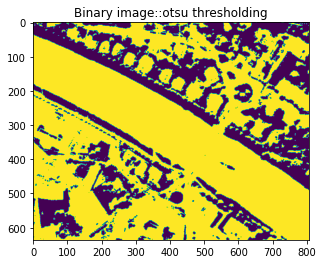

In [39]:
plt.imshow(binary)
plt.title("Binary image::otsu thresholding")

Text(0.5, 1.0, 'Water pixels extracted based on prior knowledge')

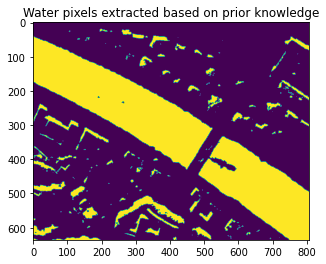

In [42]:
# manual thresholding to extract water pixel
binarized = gauss_filt < 0.002525
plt.imshow(binarized)
plt.title("Water pixels extracted based on prior knowledge")

As seen in the last code block, the output of the thresholding still presents an image filled with extra pixels as the water pixels. One way to filter out this extraneous pixels is to use a combination of opening and closing to have a proper output of the river in this image. See the code blocks below for the steps. 

Text(0.5, 1.0, 'Output of inintial opening')

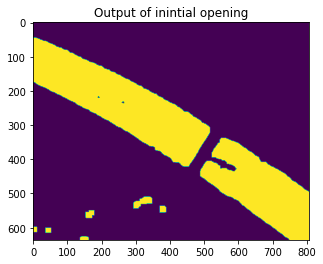

In [70]:
#Filter out the extra noise pixels using opening and closing
filtered = morphology.binary_opening(binarized, morphology.square(15)).astype(np.uint8)
plt.imshow(filtered)
plt.title("Output of inintial opening")

Text(0.5, 1.0, 'Closing of the initial opening')

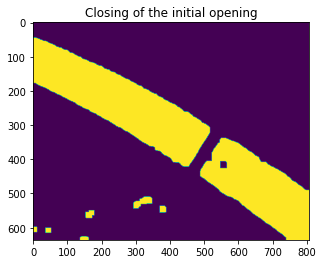

In [71]:
filtered = morphology.binary_closing(filtered, morphology.square(15)).astype(np.uint8)
plt.imshow(filtered)
plt.title("Closing of the initial opening")

Text(0.5, 1.0, 'Extracted water pixels (yellow)')

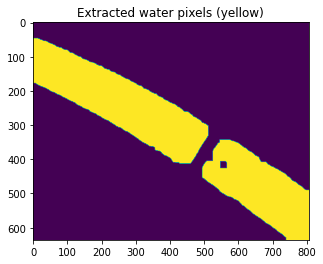

In [78]:
water = morphology.binary_opening(filtered, morphology.square(30))
plt.imshow(water)
plt.title('Extracted water pixels (yellow)')

## Bridge Extraction

[Direction augmented structuring element](https://scikit-image.org/docs/dev/auto_examples/numpy_operations/plot_structuring_elements.html#sphx-glr-auto-examples-numpy-operations-plot-structuring-elements-py)

At this point, after a series of opening and closing the water pixel was extracted as the foreground in this binarized image. The next step is to extract the background pixels that separates this two disjointed foreground elements. The area that separates these two foreground elements is assumed to be the bridge over water. 

In [143]:
# Extract the orientation of the water pixels
import math
from skimage.measure import regionprops, label

label_img = label(water)
regions = regionprops(label_img.astype(np.uint8))
for prop in regions:
  orientation = prop.orientation

angle = math.cos(orientation)
print(angle)

0.6106787362073386


Text(0.5, 1.0, 'Extracted bridge over water')

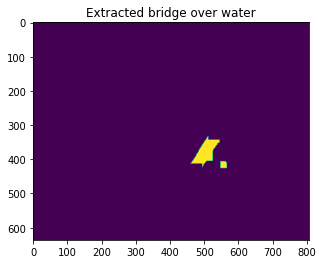

In [144]:
#Rotate the structuring element to fit that the angle of the water
from skimage.transform import rotate
rotated_se = rotate(morphology.square(50).astype(np.uint8), angle=angle)
plt.imshow(morphology.black_tophat(water, rotated_se))
plt.title('Extracted bridge over water')

Also extracted the small ship close to the bridge. This can be filtered out at a later step. 

## Conclusion

In this notebook, the workflow implemented in the paper highlighted above was replicated but for a different image due to the proprietary restrictions on the images used in the paper. Here, an IKONOS Image of Salzburg was used. The analysis used a combination of gaussian filtering, histogram thresholding and mathematical morphology to extract water and bridge feature from the original input image.
The limitation of this workflow was centered around the binarization of the image using the thresholding function to extract feature. An alternative approach of emphasizing the water features using grayscale morphology would have been a solid approach. Although, the recommended direction-augmented structuring elements approach works well in this application, it bears the potential of been computational expensive in cases of non-binarized images.
Overall, it presents a useful method specific to extracting bridges over water in a well-structured workflow. 